In [88]:
# imports
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import time



#####################################
### Provided functions start here ###
#####################################

# Image loading and saving

def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)


# Plot the height map

# def display_output(albedo_image, height_map, subject_name):
#     # Plot albedo image
#     fig = plt.figure()
#     plt.imshow(albedo_image, cmap='gray')
#     plt.axis('off')
    
#     fig = plt.figure(figsize=(20, 10))
    
#     # Plot 20°/20° angle view
#     ax1 = fig.add_subplot(1, 2, 1, projection='3d')
#     ax1.view_init(20, 20)
#     X = np.arange(albedo_image.shape[0])
#     Y = np.arange(albedo_image.shape[1])
#     X, Y = np.meshgrid(Y, X)
#     H = np.flipud(np.fliplr(height_map))
#     A = np.flipud(np.fliplr(albedo_image))
#     A = np.stack([A, A, A], axis=-1)
#     ax1.xaxis.set_ticks([])
#     ax1.xaxis.set_label_text('Z')
#     ax1.yaxis.set_ticks([])
#     ax1.yaxis.set_label_text('X')
#     ax1.zaxis.set_ticks([])
#     ax1.zaxis.set_label_text('Y')
#     ax1.plot_surface(H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    
#     # Plot side view
#     ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#     ax2.view_init(20, 90)  # 90 degrees azimuth for side view
#     ax2.xaxis.set_ticks([])
#     ax2.xaxis.set_label_text('Z')
#     ax2.yaxis.set_ticks([])
#     ax2.yaxis.set_label_text('X')
#     ax2.zaxis.set_ticks([])
#     ax2.zaxis.set_label_text('Y')
#     ax2.plot_surface(H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    
#     plt.savefig(subject_name + '_comparison.jpg')
#     plt.show()

# # Define the function to ensure the aspect ratio is equal in 3D
# def set_aspect_equal_3d(ax):
#     extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
#     sz = extents[:,1] - extents[:,0]
#     centers = np.mean(extents, axis=1)
#     maxsize = max(abs(sz))
#     r = maxsize / 2
#     for ctr, dim in zip(centers, 'xyz'):
#         getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)



def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map, subject_name):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')


    #ax.view_init(20, 20)

    # Adjust view to be from the side ax.view_init(elev=20, azim=90
    ax.view_init(elev=20, azim=90)

    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)
    plt.savefig(subject_name+'.jpg')


# Plot the surface normals

def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])


#####################################
### End of provided functions  ###
#####################################

In [ ]:
#######################################
### Your implementation starts here ###
#######################################

def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    d = imarray - ambimage[:,:,np.newaxis]
    d[d < 0] = 0
    processed_imarray = d/255
    return processed_imarray


def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    H, W, N = imarray.shape
    imarray = imarray.reshape(H*W, N).transpose()
    g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256
    albedo_image = np.linalg.norm(g, axis=0)
    surface_normals = g/albedo_image
    albedo_image = albedo_image.reshape(H,W)
    surface_normals = surface_normals.transpose().reshape(H,W,3)
    return albedo_image, surface_normals



def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    dx = surface_normals[:,:,0]/surface_normals[:,:,2]
    dy = surface_normals[:,:,1]/surface_normals[:,:,2]

    cumsum_x = np.cumsum(dx, axis=1)
    cumsum_y = np.cumsum(dy, axis=0)

    H, W, _ = surface_normals.shape
    if(integration_method == 'row'):
        start = time.time()
        res = cumsum_x[0,:]+cumsum_y
        end = time.time() 
        print(f"Row time = {(end - start)*1000} ms")
        return res
    elif(integration_method == 'column'):
        start = time.time()
        res = cumsum_x+cumsum_y[:,0][:,np.newaxis]
        end = time.time() 
        print(f"Column time = {(end - start)*1000} ms")
        return res
    elif(integration_method == 'average'):
        start = time.time()
        res = (cumsum_x[0,:]+cumsum_y+cumsum_x+cumsum_y[:,0][:,np.newaxis])/2
        end = time.time() 
        print(f"Average time = {(end - start)*1000} ms")
        return res
    elif(integration_method == 'random'):
        start = time.time()
        iterations = 4
        result = np.zeros((H, W))
        
        for y in range(H):
            for x in range(W):
                for _ in range(iterations):
                    seed = np.array([0] * x + [1] * y)
                    np.random.shuffle(seed)
                    
                    tx, ty, total_sum = 0, 0, 0
                    for step in seed:
                        if tx < x and (ty >= y or step == 0):
                            total_sum += dx[ty][tx]
                            tx += 1
                        else:
                            total_sum += dy[ty][tx]
                            ty += 1
                    
                    result[y][x] += total_sum
                result[y][x] /= iterations

        end = time.time() 
        print(f"Random time = {(end - start)*1000} ms")
        return result
    else:
        print("parameter not accpeted")

shape of amb (192, 168), imarray (192, 168, 64)
Row time = 0.08988380432128906 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


shape of amb (192, 168), imarray (192, 168, 64)
Column time = 0.08749961853027344 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


shape of amb (192, 168), imarray (192, 168, 64)
Average time = 0.5714893341064453 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


shape of amb (192, 168), imarray (192, 168, 64)


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


Random time = 11010.492086410522 ms


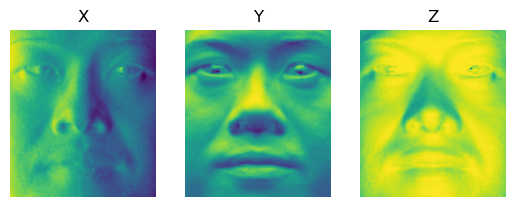

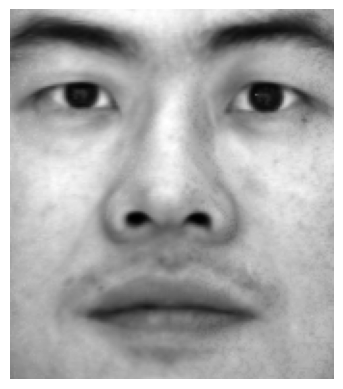

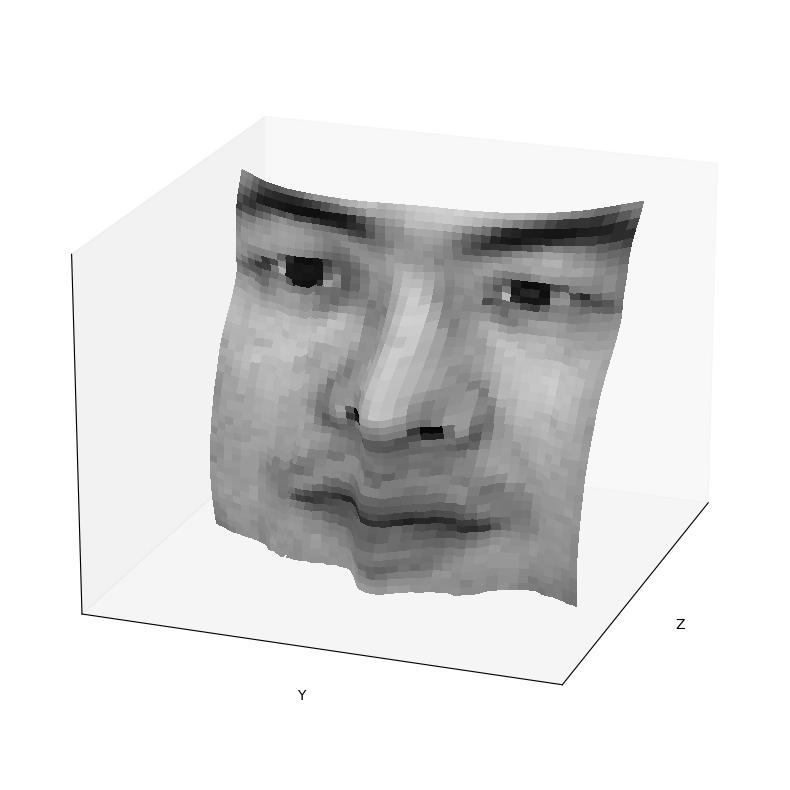

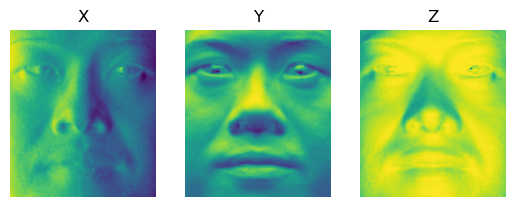

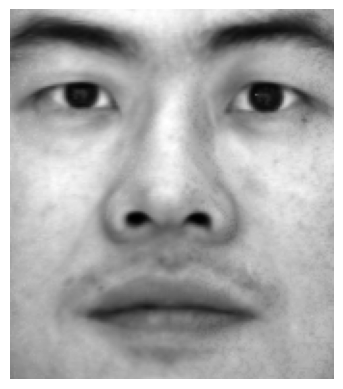

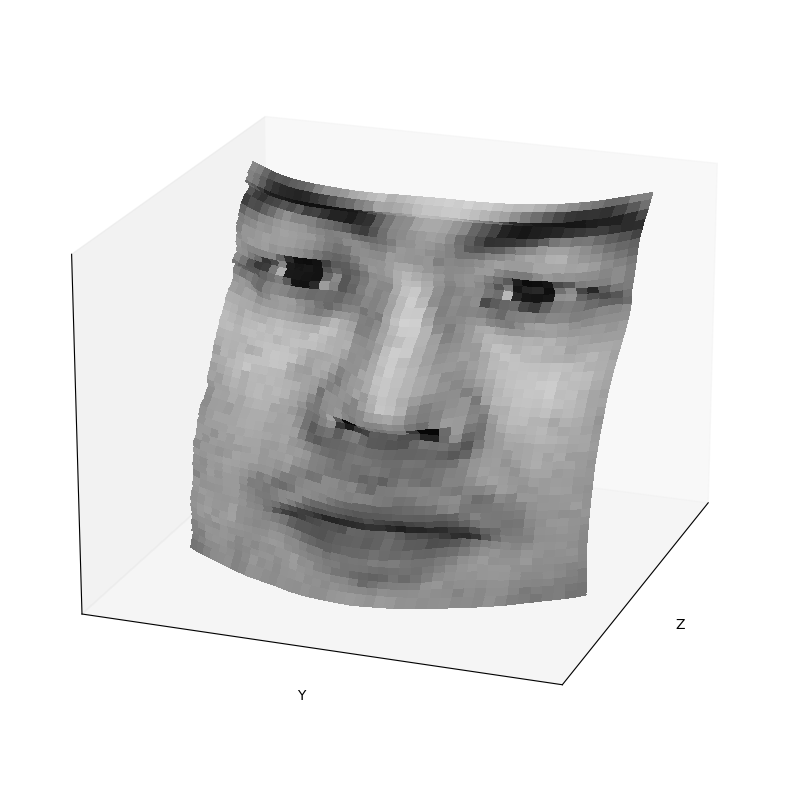

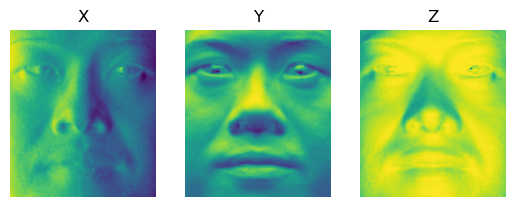

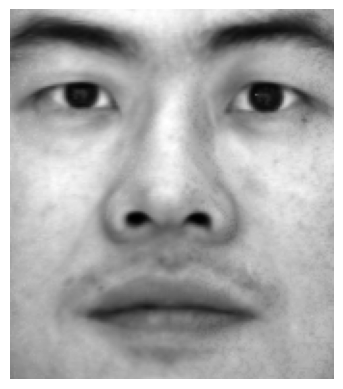

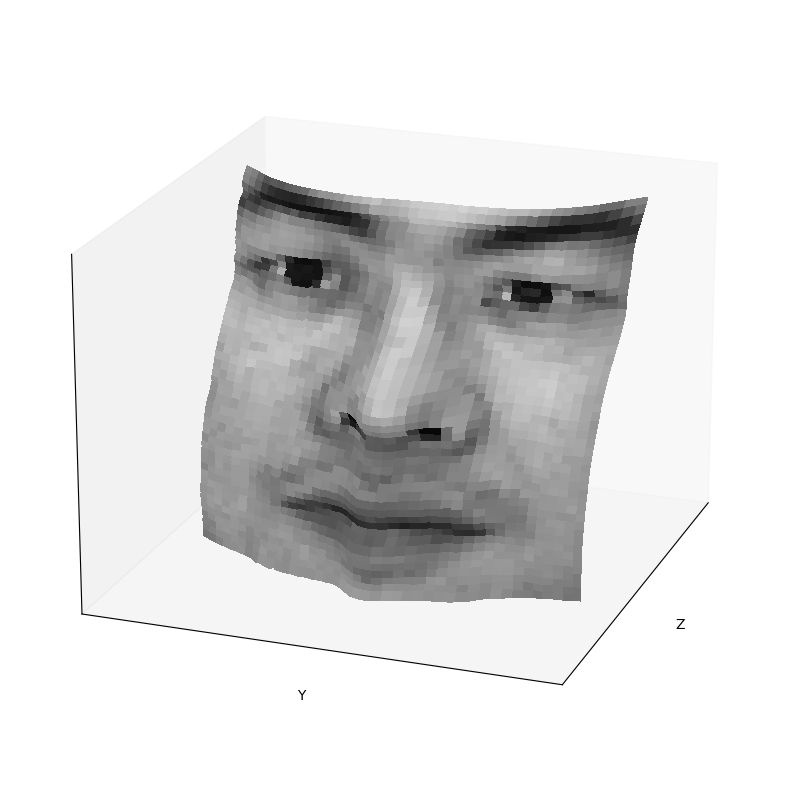

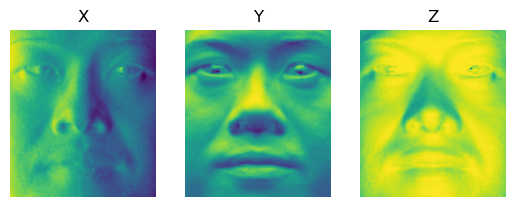

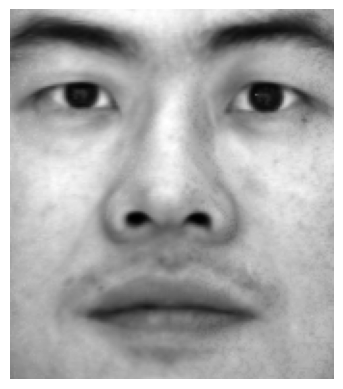

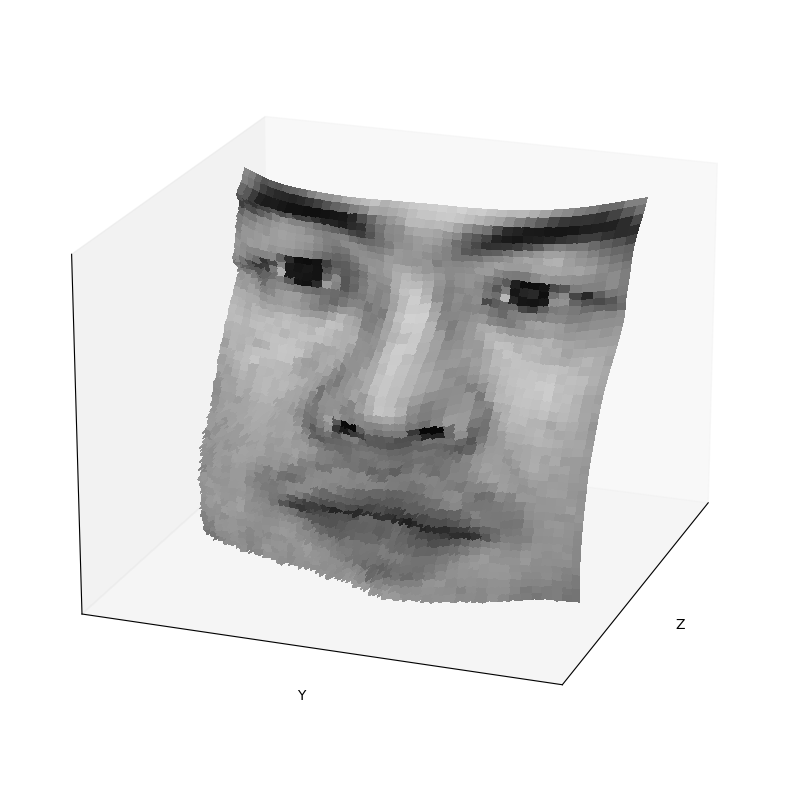

In [84]:
# Main function
if __name__ == '__main__':
    subject_name = 'yaleB02'
    root_path = 'croppedyale/'
    
    integration_methods = ['row', 'column','average', 'random']
    save_flag = False

    for integration_method in integration_methods:
        full_path = '%s%s' % (root_path, subject_name)
        ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                            64)

        print(f"shape of amb {ambient_image.shape}, imarray {imarray.shape}")
        processed_imarray = preprocess(ambient_image, imarray)

        albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                        light_dirs)

        height_map = get_surface(surface_normals, integration_method)

        if save_flag:
            save_outputs(subject_name, albedo_image, surface_normals)

        plot_surface_normals(surface_normals)

        display_output(albedo_image, height_map, subject_name)

shape of amb (192, 168), imarray (192, 168, 64)
Average time = 0.202178955078125 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


shape of amb (192, 168), imarray (192, 168, 64)
Average time = 0.16188621520996094 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


shape of amb (192, 168), imarray (192, 168, 64)
Average time = 0.2586841583251953 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


shape of amb (192, 168), imarray (192, 168, 64)
Average time = 0.14519691467285156 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


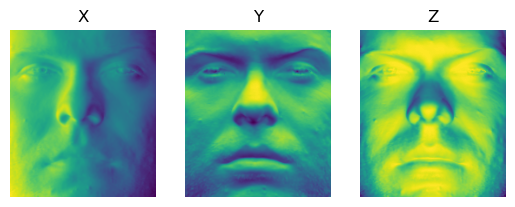

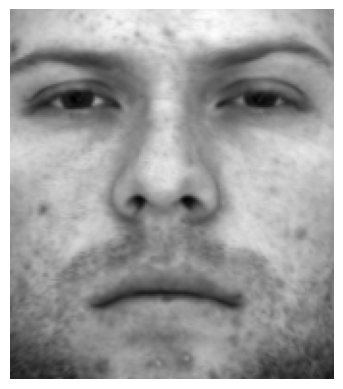

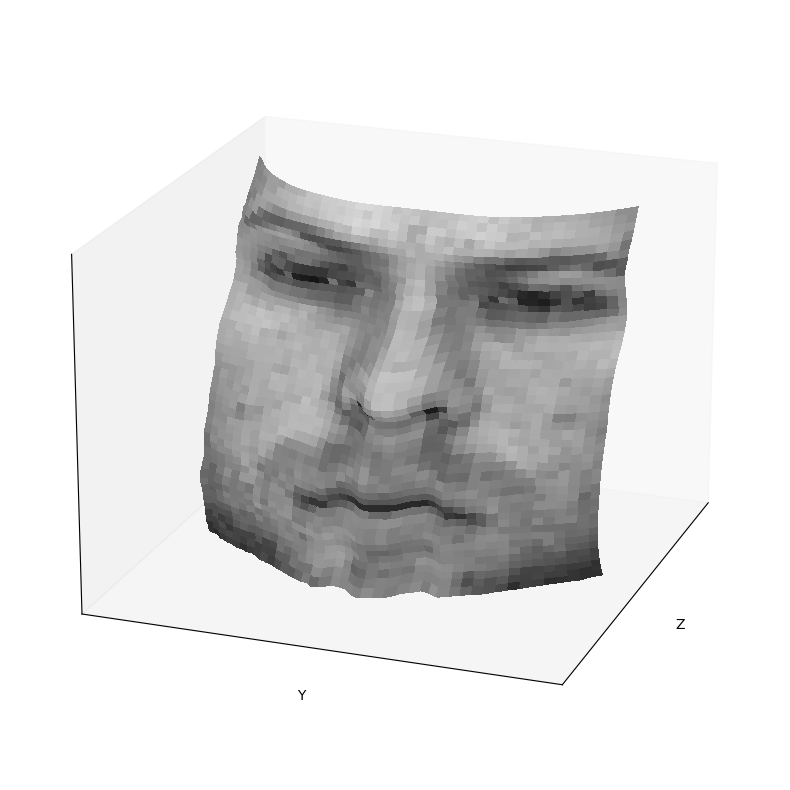

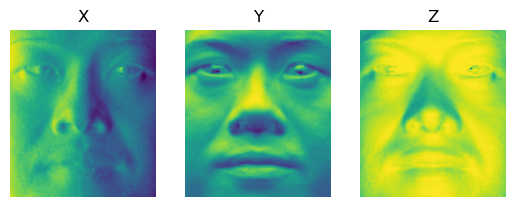

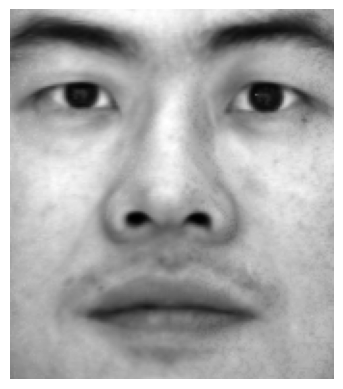

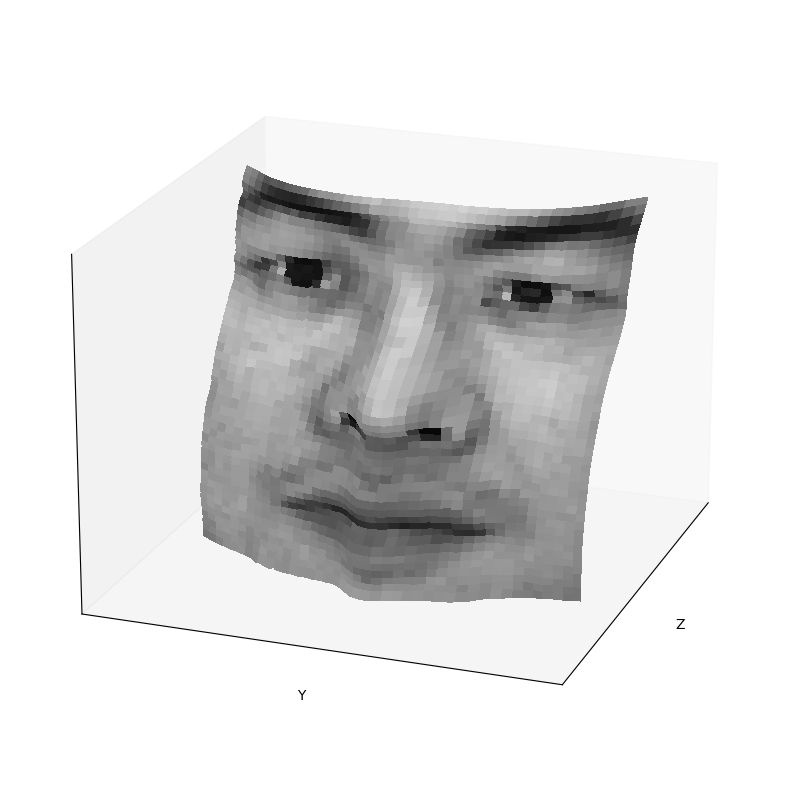

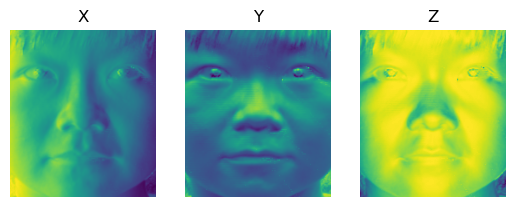

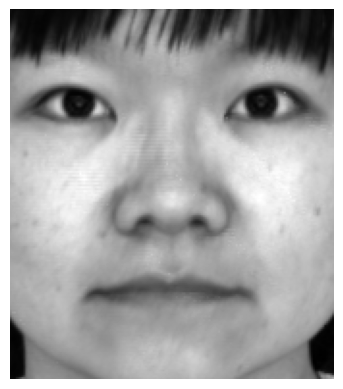

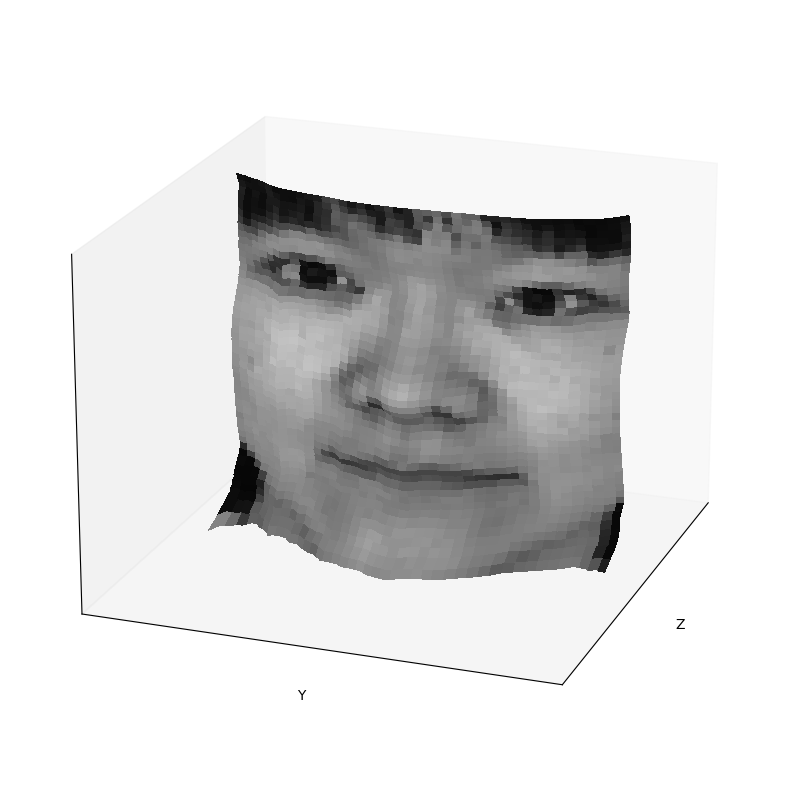

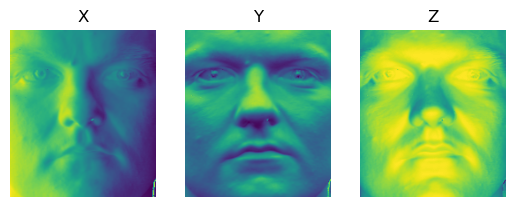

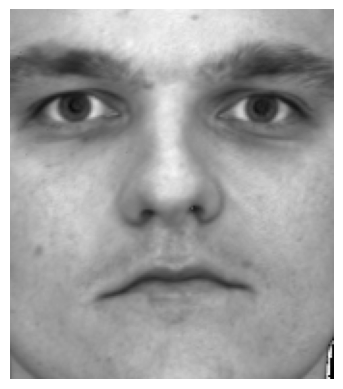

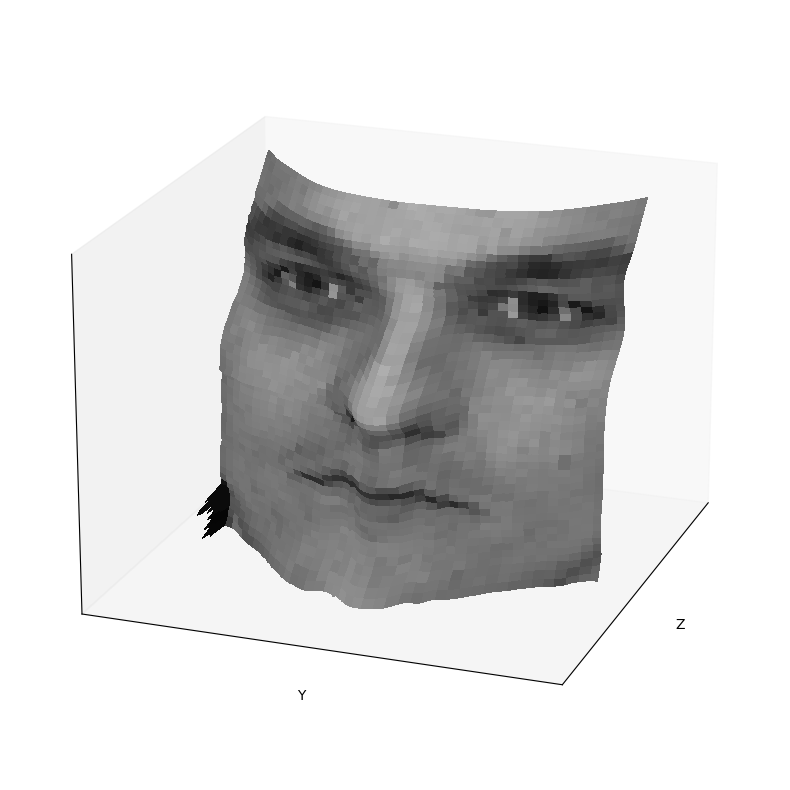

In [85]:
# Main function
if __name__ == '__main__':
    subject_names = ['yaleB01', 'yaleB02', 'yaleB05', 'yaleB07']
    root_path = 'croppedyale/'
    
    integration_method = 'average'
    save_flag = True

    for subject_name in subject_names:
        full_path = '%s%s' % (root_path, subject_name)
        ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                            64)

        print(f"shape of amb {ambient_image.shape}, imarray {imarray.shape}")
        processed_imarray = preprocess(ambient_image, imarray)

        albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                        light_dirs)

        height_map = get_surface(surface_normals, integration_method)

        if save_flag:
            save_outputs(subject_name, albedo_image, surface_normals)

        plot_surface_normals(surface_normals)

        display_output(albedo_image, height_map, subject_name)

shape of amb (192, 168), imarray (192, 168, 32)
Average time = 0.33545494079589844 ms


/tmp/ipykernel_154901/3654504745.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(light_dirs, imarray)[0]     #3*32256


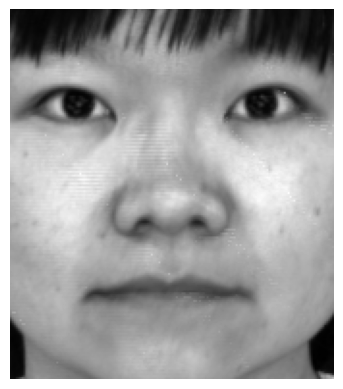

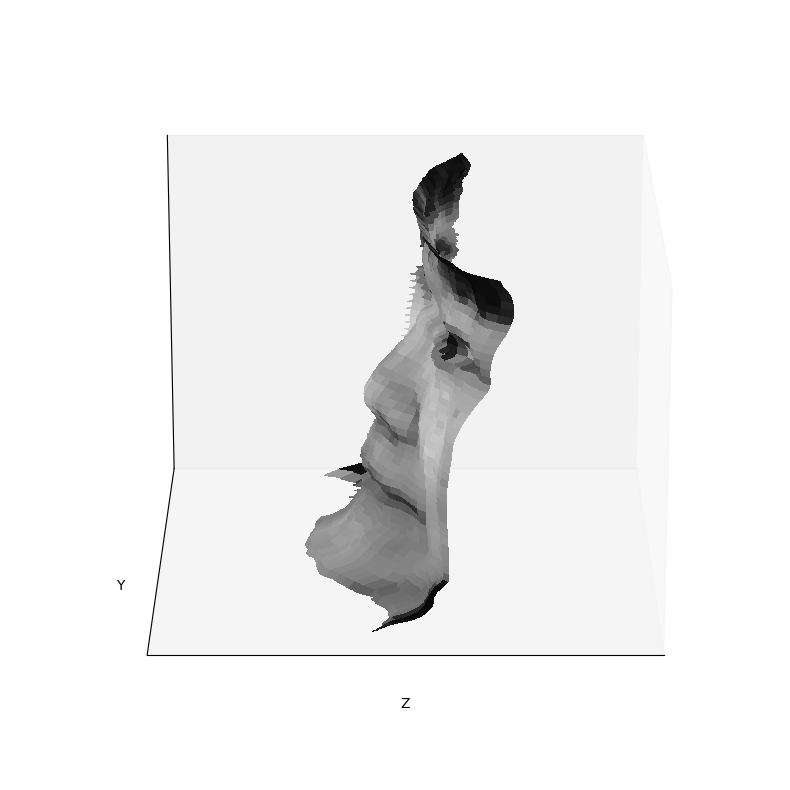

In [89]:
# part 9 and 10

#selcting a subset

# Main function
if __name__ == '__main__':
    subject_name = 'yaleB05'
    root_path = 'croppedyale/'
    
    integration_methods = 'average'
    save_flag = False

    full_path = '%s%s' % (root_path, subject_name)

    ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                        32)

    print(f"shape of amb {ambient_image.shape}, imarray {imarray.shape}")
    processed_imarray = preprocess(ambient_image, imarray)

    albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                    light_dirs)

    height_map = get_surface(surface_normals, integration_method)

    if save_flag:
        save_outputs(subject_name, albedo_image, surface_normals)

    #plot_surface_normals(surface_normals)

    display_output(albedo_image, height_map, subject_name)
